In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import sklearn
from random import sample 
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale,resize

import os

In [19]:
images_dir = "images"
labels_path = 'sample_labels.csv'
all_photos_paths = [os.path.join(images_dir,file) for file in os.listdir(images_dir)]
print(all_photos_paths[:4])
metadata = pd.read_csv(labels_path)

['images/00016522_016.png', 'images/00018500_009.png', 'images/00002570_001.png', 'images/00018055_015.png']


In [4]:
metadata.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [5]:
metadata.shape

(5606, 11)

Some photos consist of several illnesses. Let's split it so that every row has only 1 illness or no illness assigned

In [3]:
df = metadata # metadata is too long name :)
s = df['Finding Labels'].str.split('|').apply(pd.Series, 1).stack()   
s.index = s.index.droplevel(-1)
s.name = 'Illness'
del df['Finding Labels']
df = df.join(s)

In [4]:
Illness = 'Illness'
df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Illness'],
      dtype='object')

In [8]:
df[Illness].head(10)

0             Emphysema
0          Infiltration
0    Pleural_Thickening
0          Pneumothorax
1          Cardiomegaly
1             Emphysema
2            No Finding
3           Atelectasis
4          Cardiomegaly
4                 Edema
Name: Illness, dtype: object

In [9]:
df[Illness].count()

6978

In [5]:
all_illnesses = df[Illness].unique()
grouped = df.groupby([Illness]).size().reset_index(name='Count')
grouped

,Illness,Count
0,Atelectasis,508
1,Cardiomegaly,141
2,Consolidation,226
3,Edema,118
4,Effusion,644
5,Emphysema,127
6,Fibrosis,84
7,Hernia,13
8,Infiltration,967
9,Mass,284


<br>Let's plot and see how many of illnes do we have in dataset</br>

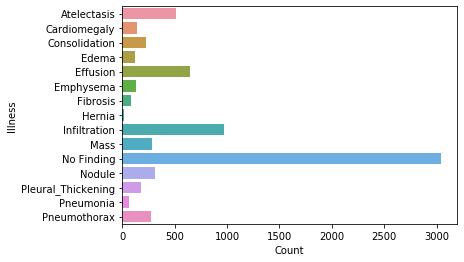

In [11]:
sns.barplot(y=Illness,x='Count',data = grouped)

<br> Now with "No finding" filtered out</br>

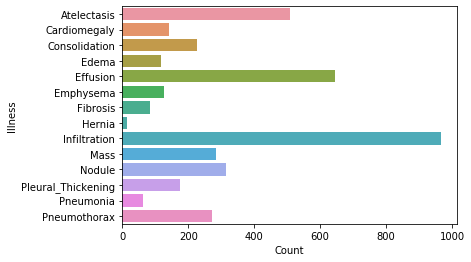

In [12]:
sns.barplot(y=Illness,x='Count',data = grouped[grouped[Illness]!='No Finding'])

From now we'll make thing easier and take just healthy people and these which have Infiltration to perform binary classification

In [6]:
df_bin = df[df.Illness.isin(['No Finding','Infiltration'])]
df_bin.shape

(4011, 11)

We still have most of our data, as we started with 5606 samples. That means that 4011 out of these are either healthy or suffer rom Infiltration

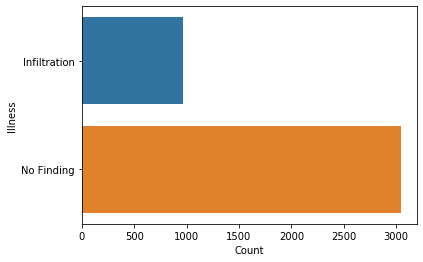

In [7]:
grouped = df_bin.groupby([Illness]).size().reset_index(name='Count')
sns.barplot(y=Illness,x='Count',data = grouped)

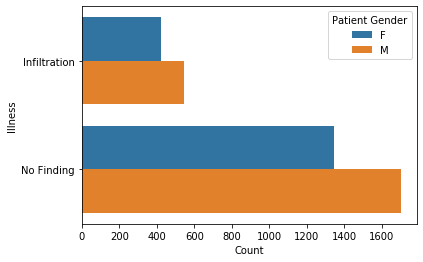

In [15]:
grouped = df_bin.groupby(['Patient Gender',Illness]).size().reset_index(name='Count')
sns.barplot(y=Illness,x='Count',hue='Patient Gender',data = grouped)

we still suffer from some imbalance. We have to remember about it when computing future model's accuracy. There is also a little overrepresentation of men comparing to women, however it's proportional in both classes, so possibly can be ommitted

<br> Let's take a look at some photos</br>


/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


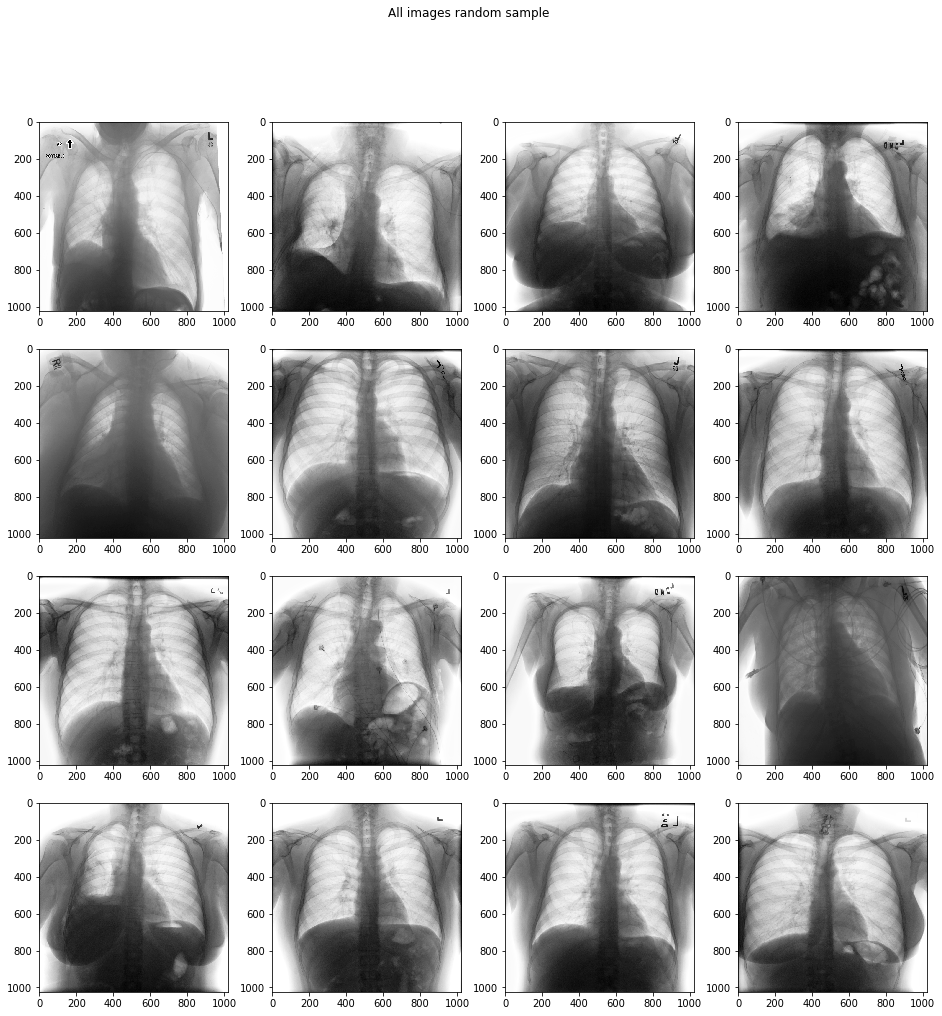

In [16]:
def draw(photos,figsize,title):
    x,y = figsize
    fig,ax = plt.subplots(x,y,figsize=(x*4,y*4))
    for i,path in enumerate(sample(photos,x*y)):
        with open(path,'rb') as f:
            image=Image.open(f)
            ax[i%x,i//y].imshow(image, cmap='Greys')
    plt.suptitle(title)
    fig.show()
draw(all_photos_paths,(4,4), "All images random sample")

In [8]:
healthy= df_bin[df_bin[Illness]=='No Finding'][['Image Index']]\
.apply(lambda path: images_dir+"/"+path).values.flatten()
sick= df_bin[df_bin[Illness]=='Infiltration'][['Image Index']]\
.apply(lambda path: images_dir+"/"+path).values.flatten()
print(type(healthy))
draw(list(healthy),(3,3),"healthy examples")


<class 'numpy.ndarray'>


NameError: name 'draw' is not defined

/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


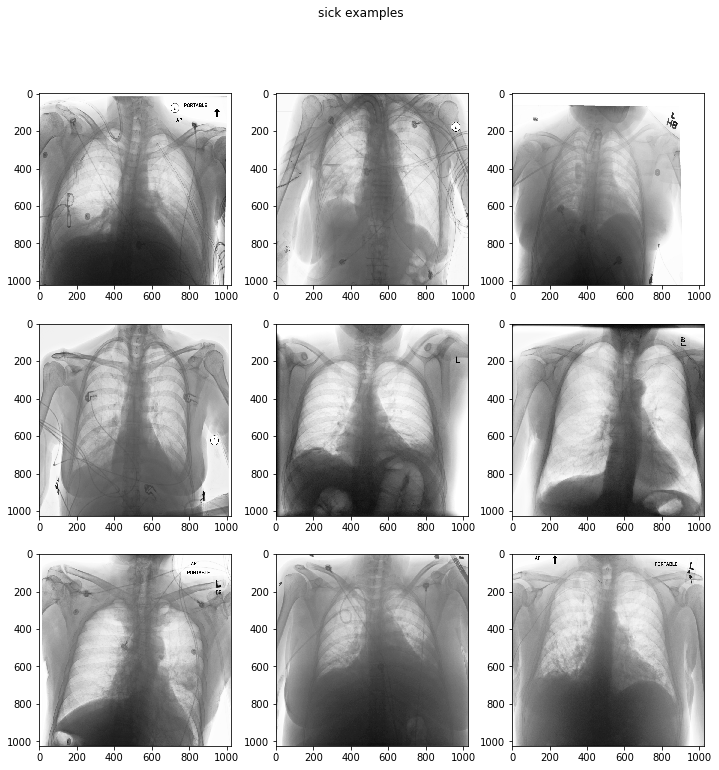

In [18]:
draw(list(sick),(3,3),"sick examples")

Ok, Let'ś start doing something! First, let's check if the images are of fixed size. We'd like to vectorize them after all.


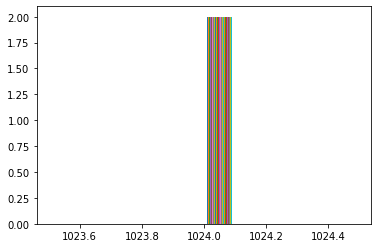

In [21]:
plt.hist([Image.open(file).size for file in all_photos_paths][:30])
plt.show()
# the chart is actually ugly but all the photos have the same size. However 1024x1024 seems to be too much for our 
# computers, so let's resize them:

In [22]:
WIDTH,HEIGHT =256,256

We will use Histogram of Oriented Gradients to reduce number of features and because it's cool :)

/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


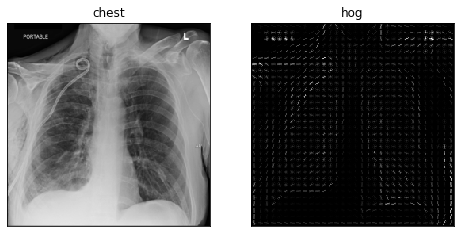

In [23]:
chest = imread(all_photos_paths[3], as_grey=True)

chest = resize(chest, (WIDTH,HEIGHT),anti_aliasing=True)
# calculate the hog and return a visual representation.
chest_hog, dog_hog_img = hog(
    chest, pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=8,
    visualise=True,
    block_norm='L2-Hys')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]

ax[0].imshow(chest, cmap='gray')
ax[0].set_title('chest')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [24]:
print('pixels: ', chest.shape[0] * chest.shape[1])
print('hog features: ', chest_hog.shape[0])

pixels:  65536
hog features:  30752


In [10]:
WIDTH,HEIGHT=256,256

as we can see - hog representation reduces number of features for over 50% in this particular example

In [30]:

from sklearn.model_selection import train_test_split
X_init = df_bin['Image Index'].values[:1000]
y_init = df_bin[Illness].values[:1000]
X = np.array([resize(imread(f'images/{photo_path}', as_grey=True), (WIDTH,HEIGHT),anti_aliasing=True) for photo_path in X_init])
y =np.array([1 if illness == 'Infiltration' else 0 for illness in y_init] )


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # cross validation will be done with scikit, no need to make another set for that, as sklearn handles it pretty well
    stratify=y
)

def prepare_train_data(size):
    X_init = df_bin['Image Index'].values[:size]
    y_init = df_bin[Illness].values[:size]
    X = np.array([resize(imread(f'images/{photo_path}', as_grey=True), (WIDTH,HEIGHT),anti_aliasing=True) for photo_path in X_init])
    y =np.array([1 if illness == 'Infiltration' else 0 for illness in y_init] )


    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2, # cross validation will be done with scikit, no need to make another set for that, as sklearn handles it pretty well
        stratify=y
    )
    return X_train, X_test, y_train, y_test 


In [39]:
print(f"% of ill in training set: {sum(y_train)/len(X_train)}")
print(f"% of ill in test set: {sum(y_test)/len(X_test)}")

% of ill in training set: 0.208
% of ill in test set: 0.208


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)

        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Let's prepare the dataset

In [13]:
from sklearn.preprocessing import StandardScaler

hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()


X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)


In [42]:
print(f'({X_train.shape[0]}, {X_train.shape[1]*X_train.shape[2]})')
print(X_train_prepared.shape)


(2000, 65536)
(2000, 34596)


And train it, at first with stochastic gradient descent

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:

X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

In [15]:
from sklearn import metrics

def evaluate(y_test,predicted):
    print(f"accuracy score: {metrics.accuracy_score(y_test,predicted)}")
    print(f"precision score: {metrics.precision_score(y_test,predicted)}")
    print(f"recall score: {metrics.recall_score(y_test,predicted)}")
    print(f"f1 score: {metrics.f1_score(y_test,predicted)}")
    cnf =metrics.confusion_matrix(y_test,predicted)
    print(f"confision matrix:\n {cnf}")
    
   
    ax= plt.subplot()
    sns.heatmap(cnf, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['No finding', 'Infiltration']) 
    ax.yaxis.set_ticklabels(['No finding', 'Infiltration'])

accuracy score: 0.77
precision score: 0.4
recall score: 0.21153846153846154
f1 score: 0.27672955974842767
confision matrix:
 [[363  33]
 [ 82  22]]


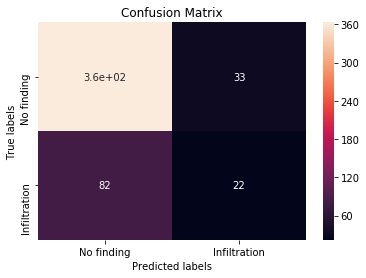

In [46]:
# Evaluate our yet duumy model
predicted = sgd_clf.predict(X_test_prepared)
evaluate(y_test,predicted)

accuracy score: 0.648
precision score: 0.20967741935483872
recall score: 0.25
f1 score: 0.22807017543859648
confision matrix:
 [[298  98]
 [ 78  26]]


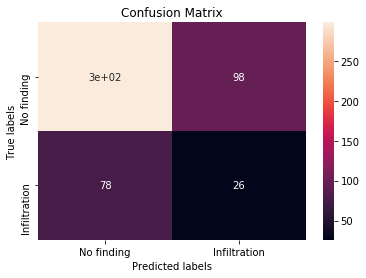

In [47]:
#Our data is skew so accuracy score may be misleading. Let's try a real dummy classification
import random
evaluate(y_test,[0 if random.random() < 0.75 else 1 for i in y_test])

I have used 0.75 because 75% of date is from healthy people. Our generic model is still better than random, but the difference is not satisfying.
Let's have some optimisations.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm


HOG_pipeline = Pipeline([
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8),
        cells_per_block=(2,2),
        orientations=9,
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])


param_grid = [ 
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(3, 3)],
     'hogify__pixels_per_cell': [(8, 8), (14, 14)],
     'classify': [
         SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
         svm.SVC(kernel='linear')]}
]

grid_search = GridSearchCV(HOG_pipeline,
                           param_grid,
                           cv=3,
                           n_jobs=8,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
grid_res = grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed: 10.9min remaining:  2.2min
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 11.8min finished


In [49]:
grid_res.best_estimator_

Pipeline(memory=None,
         steps=[('hogify',
                 HogTransformer(block_norm='L2-Hys', cells_per_block=(3, 3),
                                orientations=9, pixels_per_cell=(14, 14),
                                y=None)),
                ('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [50]:
grid_res.best_score_

0.7655

In [51]:
grid_res.best_params_

{'classify': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=42, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 'hogify__cells_per_block': (3, 3),
 'hogify__orientations': 9,
 'hogify__pixels_per_cell': (14, 14)}

accuracy score: 0.782
precision score: 0.4444444444444444
recall score: 0.19230769230769232
f1 score: 0.2684563758389262
confision matrix:
 [[371  25]
 [ 84  20]]


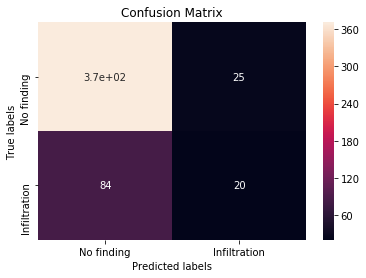

In [52]:
res = grid_res.predict(X_test)
evaluate(y_test,res)

Sounds like svc make it better than stochastic gradient. Let's get deeper then


In [22]:
svc_param_grid = [ 
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(3, 3)],
     'hogify__pixels_per_cell': [(8, 8)],
     'classify': [
         svm.SVC(kernel='linear'),
         svm.SVC(kernel='linear',C=3),
                  SGDClassifier(random_state=643, max_iter=6000, tol=1e-4),
         svm.SVC(kernel='rbf'),
         svm.SVC(kernel='rbf',gamma =0.1),
         svm.SVC(kernel='rbf',gamma =0.01),
         svm.SVC(kernel='rbf',gamma =1),
         svm.SVC(kernel='sigmoid'),
     ]}
]

def local_grid_search(param_grid,scoring):
    grid_search_svc = GridSearchCV(HOG_pipeline,
                               param_grid,
                               cv=3,
                               n_jobs=8,
                               scoring=scoring,
                               verbose=1,
                               return_train_score=True)

    grid_res_svc = grid_search_svc.fit(X_train, y_train)
    print(grid_res_svc.best_score_)
    print(grid_res_svc.best_params_)
    res = grid_res_svc.predict(X_test)
    evaluate(y_test,res)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed: 10.3min finished


0.6296296296296297
{'classify': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=6000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=643, shuffle=True, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False), 'hogify__cells_per_block': (3, 3), 'hogify__orientations': 9, 'hogify__pixels_per_cell': (8, 8)}
accuracy score: 0.655
precision score: 0.3013698630136986
recall score: 0.55
f1 score: 0.3893805309734513
confision matrix:
 [[109  51]
 [ 18  22]]


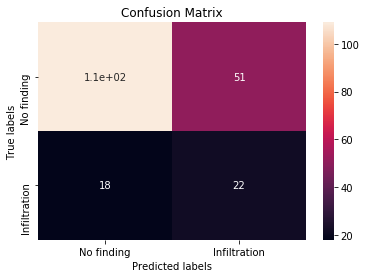

In [21]:
local_grid_search(svc_param_grid,'recall')

SVM was better for smaller problem size -500 photos. After increasing to 2500 stochastic gradient seems to perform better, however we can see there is a huge problem with recall even when Crossvalidation score is optimised for recall. Let's try to fix it by changing class weights.

class weights: {0: 0.6269592476489029, 1: 2.4691358024691357}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed: 11.1min finished


0.43161463536463535
{'classify': SVC(C=1.0, cache_size=200,
    class_weight={0: 0.6269592476489029, 1: 2.4691358024691357}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'hogify__cells_per_block': (3, 3), 'hogify__orientations': 9, 'hogify__pixels_per_cell': (8, 8)}
accuracy score: 0.725
precision score: 0.3469387755102041
recall score: 0.425
f1 score: 0.38202247191011235
confision matrix:
 [[128  32]
 [ 23  17]]


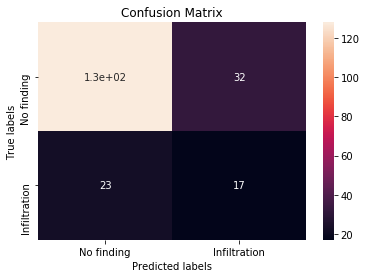

In [27]:
from sklearn.utils import class_weight
healthy_weight, ill_weight = class_weight.compute_class_weight('balanced',np.array([0,1]),y_train)
class_weights = {0: healthy_weight, 1: ill_weight}
print(f"class weights: {class_weights}")


svc_weighted_param_grid = [ 
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(3, 3)],
     'hogify__pixels_per_cell': [(8, 8)],
     'classify': [
         svm.SVC(kernel='linear',class_weight=class_weights),
         svm.SVC(kernel='linear',C=3,class_weight=class_weights),
         SGDClassifier(random_state=643, max_iter=6000, tol=1e-4,class_weight=class_weights),
         svm.SVC(kernel='rbf',class_weight=class_weights),
         svm.SVC(kernel='rbf',gamma =0.1,class_weight=class_weights),
         svm.SVC(kernel='rbf',gamma =0.01,class_weight=class_weights),
         svm.SVC(kernel='rbf',gamma =1,class_weight=class_weights),
         svm.SVC(kernel='sigmoid',class_weight=class_weights),
     ]}
]
local_grid_search(svc_weighted_param_grid,'f1')

Recall isn't the best choice considering precision, so we went towards f1 score. Let's try something more with sigmoid.

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed: 16.9min finished


0.4635566239316239
{'classify': SVC(C=1.0, cache_size=200,
    class_weight={0: 0.6269592476489029, 1: 2.4691358024691357}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'hogify__cells_per_block': (3, 3), 'hogify__orientations': 9, 'hogify__pixels_per_cell': (16, 16)}
accuracy score: 0.69
precision score: 0.328125
recall score: 0.525
f1 score: 0.40384615384615385
confision matrix:
 [[117  43]
 [ 19  21]]


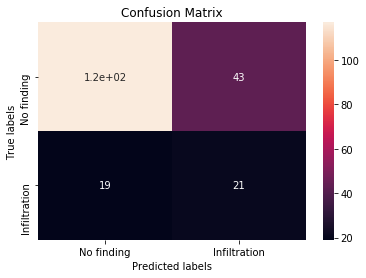

In [33]:

svc_weighted_param_grid = [ 
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(3, 3),(4,4)],
     'hogify__pixels_per_cell': [(8, 8),(16,16)],
     'classify': [
         svm.SVC(kernel='sigmoid',gamma =0.001,class_weight=class_weights),
         svm.SVC(kernel='sigmoid',gamma =0.1,class_weight=class_weights),
         svm.SVC(kernel='sigmoid',gamma =0.01,class_weight=class_weights),
         svm.SVC(kernel='sigmoid',gamma =1,class_weight=class_weights),
         svm.SVC(kernel='sigmoid',class_weight=class_weights),
     ]}
]
local_grid_search(svc_weighted_param_grid,'f1')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed: 12.4min remaining:  2.5min
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 13.1min finished


0.44303083554376654
{'classify': SVC(C=1.0, cache_size=200,
    class_weight={0: 0.6269592476489029, 1: 2.4691358024691357}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'hogify__cells_per_block': (2, 2), 'hogify__orientations': 9, 'hogify__pixels_per_cell': (8, 8)}
accuracy score: 0.735
precision score: 0.3673469387755102
recall score: 0.45
f1 score: 0.4044943820224719
confision matrix:
 [[129  31]
 [ 22  18]]


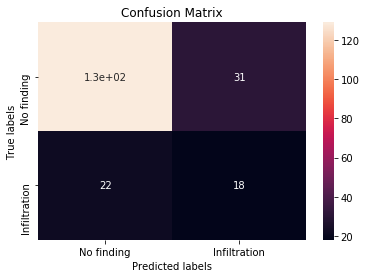

In [34]:
svc_weighted_param_grid = [ 
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(2,2),(3, 3)],
     'hogify__pixels_per_cell': [(4,4),(8, 8)],
     'classify': [
         svm.SVC(kernel='sigmoid',class_weight=class_weights),
     ]}
]
local_grid_search(svc_weighted_param_grid,'f1')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  2.5min finished


0.4274880515241592
{'classify': SVC(C=1.0, cache_size=200,
    class_weight={0: 0.6269592476489029, 1: 2.4691358024691357}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'hogify__cells_per_block': (4, 4), 'hogify__orientations': 9, 'hogify__pixels_per_cell': (8, 8)}
accuracy score: 0.715
precision score: 0.33962264150943394
recall score: 0.45
f1 score: 0.3870967741935484
confision matrix:
 [[125  35]
 [ 22  18]]


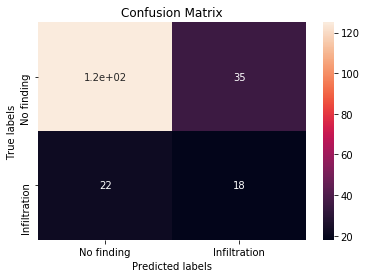

In [35]:

svc_weighted_param_grid = [ 
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(4,4)],
     'hogify__pixels_per_cell': [(8, 8)],
     'classify': [
         svm.SVC(kernel='sigmoid',class_weight=class_weights),
     ]}
]
local_grid_search(svc_weighted_param_grid,'f1')

In [ ]:
X_train, X_test, y_train, y_test  =prepare_train_data(5000)
local_grid_search(svc_weighted_param_grid,'f1')

/home/robert/PycharmProjects/medCollaboratory/venv/lib/python3.6/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
